In [1]:
import numpy as np
from importlib import reload
import interpolate_fhat_Jhat as intf
import matplotlib.pyplot as plt
import calculate_Gamma 
from scipy.interpolate import interp1d, splev, splrep
from statistics import stdev
from scipy.optimize import curve_fit

### Data

In [2]:
# Data as described in 2403.13709
z_data = np.array([0.001, 0.02, 0.02, 0.02, 0.15, 0.17, 0.18, 0.38, 0.38, 0.51, 0.70, 0.85, 0.60, 0.86, 1.40, 0.44, 0.60, 0.73, 0.978, 1.23, 1.526, 1.944])
fhat_data = np.array([0.505, 0.428, 0.398, 0.314, 0.530, 0.51, 0.36, 0.44, 0.497, 0.459, 0.473, 0.315, 0.55, 0.4, 0.482, 0.413, 0.390, 0.437, 0.379, 0.385, 0.342, 0.364])
fhat_data_errors = np.array([0.085, 0.0465, 0.065, 0.048, 0.16, 0.06, 0.09, 0.06, 0.045, 0.038, 0.041, 0.095, 0.12, 0.11, 0.116, 0.08, 0.063, 0.072, 0.176, 0.099, 0.07, 0.106])

In [3]:
# Building the full covariance, taking the one of WiggleZ measurements and of SDSS-IV quasars into account
fhat_cov_partial = np.diag(fhat_data_errors[:len(z_data)-7]**2)

covariance_wiggle = 1e-3*np.array([[6.400, 2.570, 0.000],
                                   [2.570, 3.969, 2.540], 
                                   [0.000, 2.540, 5.184]])
covariance_SDSS = 1e-2*np.array([[3.098, 0.892, 0.329, -0.021],
                                 [0.892, 0.980, 0.436, 0.076],
                                 [0.329, 0.436, 0.490, 0.350],
                                 [-0.021, 0.076, 0.350, 1.124]])

fhat_data_covariance = np.block([[fhat_cov_partial, np.zeros([np.shape(fhat_cov_partial)[0],7])],
                             [np.zeros([3,np.shape(fhat_cov_partial)[0]]),covariance_wiggle, np.zeros([3,4])],
                             [np.zeros([4, np.shape(fhat_cov_partial)[0]+3]),covariance_SDSS]])

fhat_data_current = {
    'z' : z_data,
    'mean' : fhat_data,
    'cov' : fhat_data_covariance
}

In [4]:
# Jhat baseline Polychord
maglim_zeff=np.array([0.295, 0.467, 0.626, 0.771])
Jhat_maglim=np.array([0.32546732, 0.33277392, 0.38656369, 0.35394343])
Jhat_covariance = np.array([[2.22596522e-04, 7.44557424e-05, 5.89004236e-05, 7.71102354e-05],
 [7.44557424e-05, 3.37844968e-04, 1.05329570e-04, 1.38623775e-04],
 [5.89004236e-05, 1.05329570e-04, 7.55843341e-04, 3.65660247e-04],
 [7.71102354e-05, 1.38623775e-04, 3.65660247e-04, 1.24053020e-03]])

In [5]:
Jhat_errors = np.sqrt(np.diag(Jhat_covariance))

In [6]:
Jhat_data = {
    'mean' : Jhat_maglim,
    'cov' : Jhat_covariance,
}

### Theoretical predictions

In [7]:
z_range=np.linspace(0,2,100)

#Predictions in a LCDM Universe without any fifth force present
fhat_LCDM = calculate_Gamma.fhat_LCDM(z_range)
dlnf_LCDM = np.gradient(fhat_LCDM, z_range) * (1+z_range)/fhat_LCDM #dlnf/dln(1+z)

In [8]:
Jhat_LCDM = calculate_Gamma.Jhat_LCDM(z_range, Omega_m0 = 0.328, sigma_80 = 0.852)
Jhat_derivative = np.gradient(Jhat_LCDM, z_range)

### Spline reconstruction of fhat

#### Checking the AIC and BIC for different numbers of knots

In [9]:
def IC(best_fit_values, zarray):
    chi_squared = intf.chi_squared_spline(best_fit_values, zarray, z_data = z_data, fhat_data = fhat_data, 
                                          fhat_data_covariance = fhat_data_covariance, use_covariance = True)
    AIC = 2*len(zarray)+2*chi_squared
    BIC= np.log(len(z_data))*len(zarray)+2*chi_squared
    return [chi_squared, AIC, BIC]  

In [10]:
AIC_values=[]
BIC_values=[]
chi_squared_values=[]

for n in range(3,10):

    # Calculate percentiles
    percentiles = np.linspace(0, 100, n+2)

    # Find values corresponding to percentiles
    knot_values = np.percentile(z_data, percentiles)[1:n+1]
    [best_fit_values_test, covariance_matrix_test] = intf.minuit_spline(knot_values, z_data = z_data, fhat_data = fhat_data, 
                                          fhat_data_covariance = fhat_data_covariance, use_covariance = True)
    [chi_squared, AIC, BIC]=IC(best_fit_values_test, knot_values)
    chi_squared_values.append(chi_squared/(22-n))
    AIC_values.append(AIC)
    BIC_values.append(BIC)
    
print(chi_squared_values)
print(AIC_values)
print(BIC_values)

[0.8498833809425145, 0.7723833458840795, 0.7921296507766393, 0.8392106764535627, 0.8864118578412501, 0.9451649687204933, 0.9459011450588404]
[38.29556847581555, 35.80580045182686, 36.93240812640573, 38.85474164651401, 40.592355735237504, 42.46461912417381, 42.59342977152985]
[41.568695835890495, 40.169970265260126, 42.38762039319732, 45.400996366663904, 48.22965290874572, 51.19295875104034, 52.4128118517547]


#### Spline reconstruction with four knots at MagLim redshifs, and comparison case with three knots

In [11]:
# Using maglim_zeff as knot values

# Generate best fit values (for fhat at knots) and cov matrix
[best_fit_values_maglim, covariance_matrix_maglim] = intf.minuit_spline(maglim_zeff,z_data = z_data, fhat_data = fhat_data, fhat_data_errors = fhat_data_errors, 
                                                                        fhat_data_covariance = fhat_data_covariance, use_covariance = True)

# Reconstruction at whole redshift range
fhat_reco = intf.spline_reconstruction(best_fit_values_maglim, covariance_matrix_maglim, return_covariance = True)
# This gives you fhat_reco['x'] (redshifts), fhat_reco['mean'], fhat_reco['cov'], 
# fhat_reco['mean_d1'] (derivatives), fhat_reco['cov_d1'] (covariance of derivatives), and fhat_reco['cov_01'] (cov. between values of the function and its derivatives)

# Reconstruction at MagLim redshifts
fhat_reco_maglim = intf.spline_reconstruction(best_fit_values_maglim, covariance_matrix_maglim, zarray = maglim_zeff, z_range = maglim_zeff, return_covariance = True)

In [12]:
# Comparison case with three knots (as a comparison)
# Note: Placement of these three knots does not matter, see paper for more explanation
three_knot_values = np.array([0.5,1.0,1.5])

# Generate best fit values (for fhat at knots) and cov matrix
[best_fit_values_maglim_3knots, covariance_matrix_maglim_3knots] = intf.minuit_spline(three_knot_values, z_data = z_data, fhat_data = fhat_data, 
                                                                          fhat_data_errors = fhat_data_errors, fhat_data_covariance = fhat_data_covariance, use_covariance = True)

# Reconstruction at whole redshift range
fhat_reco_3knots = intf.spline_reconstruction(best_fit_values_maglim_3knots, covariance_matrix_maglim_3knots, return_covariance = True, zarray = three_knot_values)

# Reconstruction at MagLim redshifts
fhat_reco_maglim_3knots = intf.spline_reconstruction(best_fit_values_maglim_3knots, covariance_matrix_maglim_3knots, zarray=three_knot_values, 
                                              z_range = maglim_zeff, return_covariance = True)

In [13]:
# Standard devs. for the reconstruction of fhat 
# Baseline case (Knots at MagLim redshifts)
fhat_stdev = np.sqrt(np.diag(fhat_reco['cov'])) # at whole redshift range
fhat_stdev_maglim = np.sqrt(np.diag(fhat_reco_maglim['cov'])) # at MagLim redshifts

# Comparison case with three knots
fhat_stdev_3knots = np.sqrt(np.diag(fhat_reco_3knots['cov'])) # at whole redshift range
fhat_stdev_maglim_3knots = np.sqrt(np.diag(fhat_reco_maglim_3knots['cov'])) # at MagLim redshifts

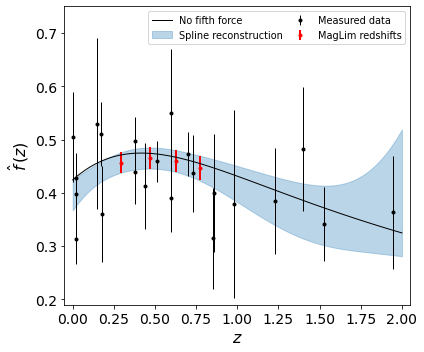

In [14]:
### Plot reconstruction of fhat (baseline case) with inferred values at MagLim redshifts

plt.figure(figsize=(6, 5))

# Prediction without a fifth force
plt.plot(z_range, fhat_LCDM, label='No fifth force', color = 'black', linewidth = 1)


# Plot measured data
plt.errorbar(z_data, fhat_data, yerr = fhat_data_errors, fmt = '.', label = 'Measured data', color = 'black', elinewidth=1)
    

# Plot reconstructed function
plt.fill_between(fhat_reco['x'], fhat_reco['mean']+fhat_stdev, fhat_reco['mean']-fhat_stdev, 
                 color='C0', alpha = 0.3, label='Spline reconstruction')
        
# Plot inferred values at MagLim redshifts
plt.errorbar(maglim_zeff, fhat_reco_maglim['mean'], fmt = '.', yerr = fhat_stdev_maglim, 
             label='MagLim redshifts', color = 'red', linewidth = 2)


ticks = [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]
plt.xticks(ticks,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$z$", fontsize=16)
plt.ylabel("$\hat{f}\,(z)$", fontsize=16)
plt.xlim(-0.05,2.05)
plt.ylim(0.19,0.75)
plt.legend(ncol=2, prop={'size': 9.8},  columnspacing=0.7, fontsize = 12)
plt.tight_layout()
plt.savefig("Figures/results_fhat_interpolation.pdf",dpi=600, bbox_inches='tight')
plt.show()

In [15]:
# Produce source data file for Fig1, left panel
# Open file and write
with open("Source_Data_Files/figure1.txt", "w") as f:
    f.write("#Left panel: Reconstruction of fhat.\n")
    f.write("#Measured data\n")
    f.write("#z\tfhat\terrors\n")  # column headers
    
    # Write data rows
    for z, fhat, err in zip(z_data, fhat_data, fhat_data_errors):
        f.write(f"{z:.6f}\t{fhat:.6f}\t{err:.6f}\n")
        
    # One blank line
    f.write("\n")
    
    # Second block
    f.write("#Reconstruction at MagLim redshifts\n")
    f.write("z\tfhat\tfhat_error\n")
    for z, mean, err in zip(maglim_zeff, fhat_reco_maglim["mean"], fhat_stdev_maglim):
        f.write(f"{z:.6f}\t{mean:.6f}\t{err:.6f}\n")        
        
    # One blank line
    f.write("\n")
    
    # Third block
    f.write("#Spline reconstruction\n")
    f.write("#z\tfhat\tfhat_error\n")
    for z, mean, err in zip(z_range, fhat_reco["mean"], fhat_stdev):
        f.write(f"{z:.6f}\t{mean:.6f}\t{err:.6f}\n")

    # One blank line
    f.write("\n")
    
    # Fourth block
    f.write("#Standard prediction without a fifth force\n")
    f.write("#z\tfhat\n")
    for z, fhat in zip(z_range, fhat_LCDM):
        f.write(f"{z:.6f}\t{fhat:.6f}\n")

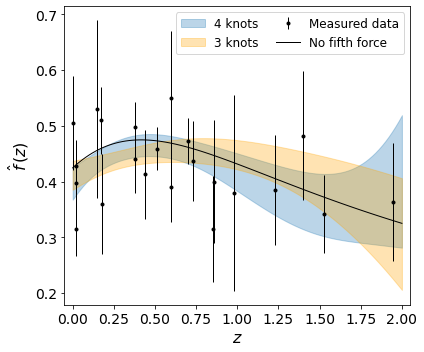

In [16]:
### Plot of fhat, comparison between 4 knots and 3 knots

plt.figure(figsize=(6, 5))

#Plot the LCDM prediction with no fifth force
StandardPrediction = plt.plot(z_range, fhat_LCDM, label='No fifth force', color = 'black', linewidth = 1)[0]


#Plot measured data
data = plt.errorbar(z_data, fhat_data, yerr = fhat_data_errors, fmt = '.', label = 'Measured data', color = 'black', elinewidth=1)
    

#Plot reconstructed functions

fill1 = plt.fill_between(fhat_reco['x'], fhat_reco['mean']+fhat_stdev, fhat_reco['mean']-fhat_stdev, 
                 color='C0', alpha = 0.3, label='4 knots')

fill2 = plt.fill_between(fhat_reco_3knots['x'], fhat_reco_3knots['mean']+fhat_stdev_3knots, fhat_reco_3knots['mean']-fhat_stdev_3knots, 
                 color='orange', alpha = 0.3, label='3 knots')
        
    

ticks = [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]
plt.xticks(ticks,fontsize=14)
plt.yticks(fontsize=14)
handles = [fill1, fill2, data, StandardPrediction]
labels = ['4 knots', '3 knots', 'Measured data', 'No fifth force']
plt.legend(handles, labels, fontsize=12, ncol=2, columnspacing=1.4)
plt.xlabel("$z$", fontsize=16)
plt.ylabel("$\hat{f}\,(z)$", fontsize=16)
plt.xlim(-0.05,2.05)
plt.tight_layout()
plt.savefig("Figures/results_fhat_3_4.pdf",dpi=600, bbox_inches='tight')
plt.show()

In [17]:
# Produce source data file for Supplementary Fig1, left panel
# Open file and write
with open("Source_Data_Files/supplementary_figure1.txt", "w") as f:
    f.write("#Left panel: Reconstruction of fhat.\n")
    f.write("#Measured data\n")
    f.write("#z\tfhat\tfhat_error\n")  # column headers
    
    # Write data rows
    for z, fhat, err in zip(z_data, fhat_data, fhat_data_errors):
        f.write(f"{z:.6f}\t{fhat:.6f}\t{err:.6f}\n")     
        
    # One blank line
    f.write("\n")
    
    # Third block
    f.write("#Spline reconstruction with 4 knots\n")
    f.write("#z\tfhat\tfhat_error\n")
    for z, mean, err in zip(z_range, fhat_reco["mean"], fhat_stdev):
        f.write(f"{z:.6f}\t{mean:.6f}\t{err:.6f}\n")
        
        
    # One blank line
    f.write("\n")
    
    # Third block
    f.write("#Spline reconstruction with 3 knots\n")
    f.write("#z\tfhat\tfhat_error\n")
    for z, mean, err in zip(z_range, fhat_reco_3knots["mean"], fhat_stdev_3knots):
        f.write(f"{z:.6f}\t{mean:.6f}\t{err:.6f}\n")
        

    # One blank line
    f.write("\n")
    
    # Fourth block
    f.write("#Standard prediction without a fifth force\n")
    f.write("#z\tfhat\n")
    for z, fhat in zip(z_range, fhat_LCDM):
        f.write(f"{z:.6f}\t{fhat:.6f}\n")

### Calculating dlnf(z) and Gamma(z) with covariances at MagLim values

In [18]:
# The following computes \Gamma(z) and d\ln(\hat{f})(z)/d\ln(1+z) and their covariances at LSST redshifts
# Baseline case with 4 knots at MagLim redshifts
[Gamma_maglim, Gamma_cov_maglim, dlnf_mean_maglim, dlnf_cov_maglim]=calculate_Gamma.Gamma_reco(fhat_reco_maglim, Jhat_data, include_cov01 = True)
err_Gamma_maglim = np.sqrt(np.diag(Gamma_cov_maglim))
err_dlnf_maglim = np.sqrt(np.diag(dlnf_cov_maglim))

# Comparison with 3 knots
[Gamma_maglim_3knots, Gamma_cov_maglim_3knots, dlnf_mean_maglim_3knots, dlnf_cov_maglim_3knots]=calculate_Gamma.Gamma_reco(fhat_reco_maglim_3knots, Jhat_data, include_cov01 = True)
err_Gamma_maglim_3knots = np.sqrt(np.diag(Gamma_cov_maglim_3knots))
err_dlnf_maglim_3knots = np.sqrt(np.diag(dlnf_cov_maglim_3knots))

### Reconstruction of dln(f) over whole redshift range

In [19]:
[dlnf, dlnf_cov] = calculate_Gamma.dlnf_dln1pz(fhat_reco)
err_dlnf = np.sqrt(np.diag(dlnf_cov))

[dlnf_3knots, dlnf_cov_3knots] = calculate_Gamma.dlnf_dln1pz(fhat_reco_3knots)
err_dlnf_3knots = np.sqrt(np.diag(dlnf_cov_3knots))

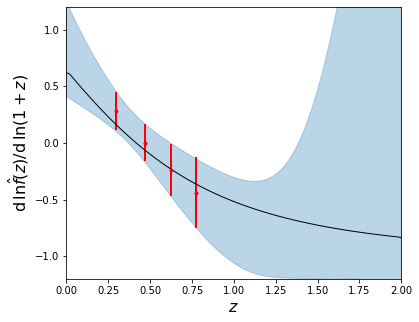

In [20]:
# Plotting d\ln(\hat{f})(z)/d\ln(1+z) for the baseline case (4 knots), showing maglim redshifts
plt.figure(figsize=(6, 5))

# Plot theoretical prediction without fifth force
line = plt.plot(z_range, dlnf_LCDM, color='black', label='No fifth force', linewidth=1)[0]

# Plot spline reconstruction
fill1 = plt.fill_between(
    fhat_reco['x'],
    dlnf - err_dlnf,
    dlnf + err_dlnf,
    color='C0',
    alpha=0.3,
    label='4 knots'
)

# Plot inferred values at maglim redshifts
plt.errorbar(maglim_zeff, dlnf_mean_maglim, fmt = '.', yerr = err_dlnf_maglim, 
             label='MagLim redshifts', color = 'red', linewidth = 2)


plt.xlabel("$z$", fontsize=16)
plt.ylabel('$\\mathrm{d}\,\ln\hat{f}(z)/\\mathrm{d}\,\ln(1+z)$', fontsize = 16)
plt.xlim(0.0,2.0)
plt.ylim(-1.2,1.2)

plt.savefig("Figures/dlnf.pdf", dpi=600, bbox_inches='tight')

In [23]:
#Append right panel data to Fig1 source file
with open("Source_Data_Files/figure1.txt", "a") as f:
    # Three blank lines
    f.write("\n\n\n")
    
    # Right panel block
    f.write("#Right panel: Reconstruction of the derivative dlnf(z)/dln(1+z)\n")
    f.write("Reconstruction at MagLim redshifts\n")
    f.write("#z\tdlnf\tdlnf_error\n")
    for z, val, err in zip(maglim_zeff, dlnf_mean_maglim, err_dlnf_maglim):
        f.write(f"{z:.6f}\t{val:.6f}\t{err:.6f}\n")
    
     # One blank line
    f.write("\n")
    
    # Spline reconstruction block
    f.write("#Spline reconstruction\n")
    f.write("#z\tdlnf\tdlnf_error\n")
    for z, val, err in zip(z_range, dlnf, err_dlnf):
        f.write(f"{z:.6f}\t{val:.6f}\t{err:.6f}\n")
    
    # One blank line
    f.write("\n")
    
    # Standard prediction block
    f.write("#Standard prediction without a fifth force\n")
    f.write("#z\tdlnf\n")
    for z, val in zip(z_range, dlnf_LCDM):
        f.write(f"{z:.6f}\t{val:.6f}\n")

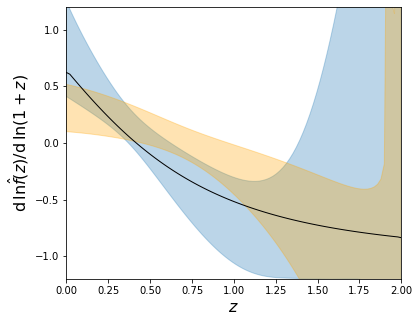

In [24]:
# Plotting d\ln(\hat{f})(z)/d\ln(1+z), comparing the baseline case (4 knots) with 3 knots

plt.figure(figsize=(6, 5))

fill1 = plt.fill_between(
    fhat_reco['x'],
    dlnf - err_dlnf,
    dlnf + err_dlnf,
    color='C0',
    alpha=0.3,
    label='4 knots'
)

fill2 = plt.fill_between(
    fhat_reco_3knots['x'],
    dlnf_3knots - err_dlnf_3knots,
    dlnf_3knots + err_dlnf_3knots,
    color='orange',
    alpha=0.3,
    label='3 knots'
)



plt.xlabel("$z$", fontsize=16)
plt.ylabel('$\\mathrm{d}\,\ln\hat{f}(z)/\\mathrm{d}\,\ln(1+z)$', fontsize = 16)
plt.xlim(0.0,2.0)
plt.ylim(-1.2,1.2)

errbar = plt.errorbar([1], [-10], yerr=[0.01], fmt='.', label='Measured $f\sigma_8$ data',
                      color='black', elinewidth=1)

line = plt.plot(z_range, dlnf_LCDM, color='black', label='No fifth force', linewidth=1)[0]


plt.savefig("Figures/dlnf_3_4.pdf", dpi=600, bbox_inches='tight')

In [25]:
#Append right panel data to Fig1 source file
with open("Source_Data_Files/supplementary_figure1.txt", "a") as f:
    # Three blank lines
    f.write("\n\n\n")
    
    # Right panel block
    f.write("#Right panel: Reconstruction of the derivative dlnf(z)/dln(1+z)\n")
    # Spline reconstruction block, 4 knots
    f.write("#Spline reconstruction with 4 knots\n")
    f.write("#z\tdlnf\tdlnf_error\n")
    for z, val, err in zip(z_range, dlnf, err_dlnf):
        f.write(f"{z:.6f}\t{val:.6f}\t{err:.6f}\n")
    
    # One blank line
    f.write("\n")
    
    # Spline reconstruction block, 3 knots
    f.write("#Spline reconstruction with 3 knots\n")
    f.write("#z\tdlnf\tdlnf_error\n")
    for z, val, err in zip(z_range, dlnf_3knots, err_dlnf_3knots):
        f.write(f"{z:.6f}\t{val:.6f}\t{err:.6f}\n")
    
    # One blank line
    f.write("\n")
    
    
    # Standard prediction block
    f.write("#Standard prediction without a fifth force\n")
    f.write("#z\tdlnf\n")
    for z, val in zip(z_range, dlnf_LCDM):
        f.write(f"{z:.6f}\t{val:.6f}\n")

### Plotting Gamma at maglim redshifts

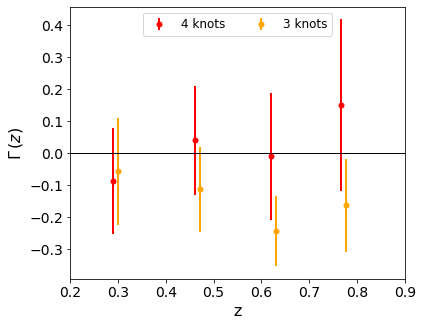

In [26]:
plt.figure(figsize=(6, 5))

plt.plot(np.linspace(0.2,0.9,50), np.full(50, 0), color='black', linewidth=1.0)

# Plot the measured data with larger markers and wider error bars
plt.errorbar(maglim_zeff-0.005, Gamma_maglim - 1, yerr=err_Gamma_maglim, fmt='.', markersize=10, elinewidth=2, color = 'red', label = '4 knots')

# Plot the measured data with larger markers and wider error bars
plt.errorbar(maglim_zeff+0.005, Gamma_maglim_3knots - 1, yerr=err_Gamma_maglim_3knots, fmt='.', markersize=10, elinewidth=2, color = 'orange', label = '3 knots')


plt.xlabel("z", fontsize=16)
plt.ylabel("$\Gamma\,(z)$", fontsize=16)
plt.xlim(0.2,0.9)
# plt.ylim(ylim_lower, ylim_upper)
plt.legend(ncol = 2, loc = 'upper center', fontsize = 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("Figures/results_Gamma_3_4.pdf", dpi=600, bbox_inches='tight')

In [27]:
#Append right panel data to Supp. Fig2 source file
with open("Source_Data_Files/supplementary_figure2.txt", "w") as f:
    f.write("#Constraint on Gamma with current data\n")
    # 4 knots
    f.write("#Measurement at MagLim redshifts, 4 knots\n")
    f.write("#z\tGamma\tGamma_error\n")
    for z, g, err in zip(maglim_zeff, Gamma_maglim, err_Gamma_maglim):
        f.write(f"{z:.6f}\t{g:.6f}\t{err:.6f}\n")
    
    # Blank line
    f.write("\n")
    
    # 3 knots
    f.write("#Measurement at MagLim redshifts, 3 knots\n")
    f.write("#z\tGamma\tGamma_error\n")
    for z, g, err in zip(maglim_zeff, Gamma_maglim_3knots, err_Gamma_maglim_3knots):
        f.write(f"{z:.6f}\t{g:.6f}\t{err:.6f}\n")

### Comparison with special cases (Gamma constant over observed redshift range, or Gamma evolving in proportion to dark energy density)

In [28]:
# Computing mean and standard dev. for the constant Gamma case
def const_Gamma(z, Gamma_const_val):
    return Gamma_const_val

[const_Gamma_mean, const_Gamma_stdev2] = curve_fit(const_Gamma, maglim_zeff, Gamma_maglim, sigma=Gamma_cov_maglim, absolute_sigma=True)
const_Gamma_stdev = np.sqrt(const_Gamma_stdev2)
print(const_Gamma_mean, const_Gamma_stdev)

[0.9297024] [[0.14036834]]


In [29]:
# Computing mean and standard dev. when Gamma is evolving in proportion to DE density

Omm0 = 0.311
OmL0 = 1 - 0.311

def Omega_L(z):
    return OmL0/(OmL0+Omm0*(1+z)**3)

def Gamma_DE(z, Gamma0):
    return 1+Gamma0*Omega_L(z)/OmL0

[Gamma0_mean, Gamma0_stdev2] = curve_fit(Gamma_DE, maglim_zeff, Gamma_maglim, sigma=Gamma_cov_maglim, absolute_sigma=True)
Gamma0_stdev = np.sqrt(Gamma0_stdev2)
print(Gamma0_mean, Gamma0_stdev)

[-0.12412186] [[0.21349804]]


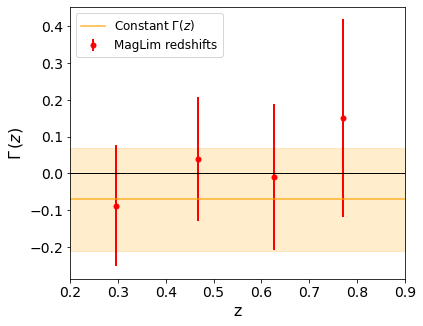

In [30]:
plt.figure(figsize=(6, 5))

color_fit = 'orange'

plt.plot([0.2,0.9], [0,0], color='black', linewidth=1.0) 

# Measured data at MagLim redshifts
plt.errorbar(maglim_zeff, Gamma_maglim - 1, yerr=err_Gamma_maglim, fmt='.', markersize=10, elinewidth=2, color = 'red', label = 'MagLim redshifts')

# Fifth force constant in observed redshift range
plt.plot(np.linspace(0.2,0.9,2), np.full(2, const_Gamma_mean-1), color=color_fit, linewidth=1.5, alpha = 0.8, label='Constant $\Gamma(z)$')
plt.fill_between([0.2,0.9], np.full(2,const_Gamma_mean-1-const_Gamma_stdev), np.full(2,const_Gamma_mean-1+const_Gamma_stdev), 
                 color=color_fit, alpha = 0.2)

# Fifth force evolving with DE density
#plt.plot(np.linspace(0.2,0.9,100), Gamma_DE(np.linspace(0.2,0.9,100), Gamma0_mean)-1, color='blue', alpha = 0.8, linewidth=1.5, label = '$\Gamma(z)$ evolving with DE')
#plt.plot(np.linspace(0.2,0.9,100), Gamma_DE(np.linspace(0.2,0.9,100), Gamma0_mean+Gamma0_stdev[0])-1,'--', color='blue', alpha = 0.8, linewidth=1.)
#plt.plot(np.linspace(0.2,0.9,100), Gamma_DE(np.linspace(0.2,0.9,100), Gamma0_mean-Gamma0_stdev[0])-1,'--', color='blue', alpha = 0.8, linewidth=1.)


plt.xlabel("z", fontsize=16)
plt.ylabel("$\Gamma\,(z)$", fontsize=16)
plt.xlim(0.2,0.9)
plt.legend(fontsize = 12, loc = 'upper left')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("Figures/results_Gamma.pdf", dpi=600, bbox_inches='tight')

In [31]:
with open("Source_Data_Files/figure2.txt", "w") as f:
    # First block
    f.write("#Constraint on Gamma with current data\n")
    f.write("#Measurement at MagLim redshifts\n")
    f.write("#z\tGamma\tGamma_error\n")
    for z, g, err in zip(maglim_zeff, Gamma_maglim, err_Gamma_maglim):
        f.write(f"{z:.6f}\t{g:.6f}\t{err:.6f}\n")
    
    # Blank line
    f.write("\n")
    
    # Second block
    f.write("#Constant fifth force in observed redshift range\n")
    f.write("#Gamma\tGamma_error\n")
    f.write(f"{const_Gamma_mean[0]:.6f}\t{const_Gamma_stdev[0,0]:.6f}\n")